# Routing:
Routing in RAG (Retrieval-Augmented Generation) refers to the process of directing a query or its components to the most appropriate knowledge sources, retrievers, or models based on the query's content, intent, or domain. This ensures that the system retrieves the most relevant and accurate information to enhance the quality of the generated response.

## 1. Logical Routing
Ref: https://towardsdatascience.com/rags-with-query-routing-5552e4e41c54
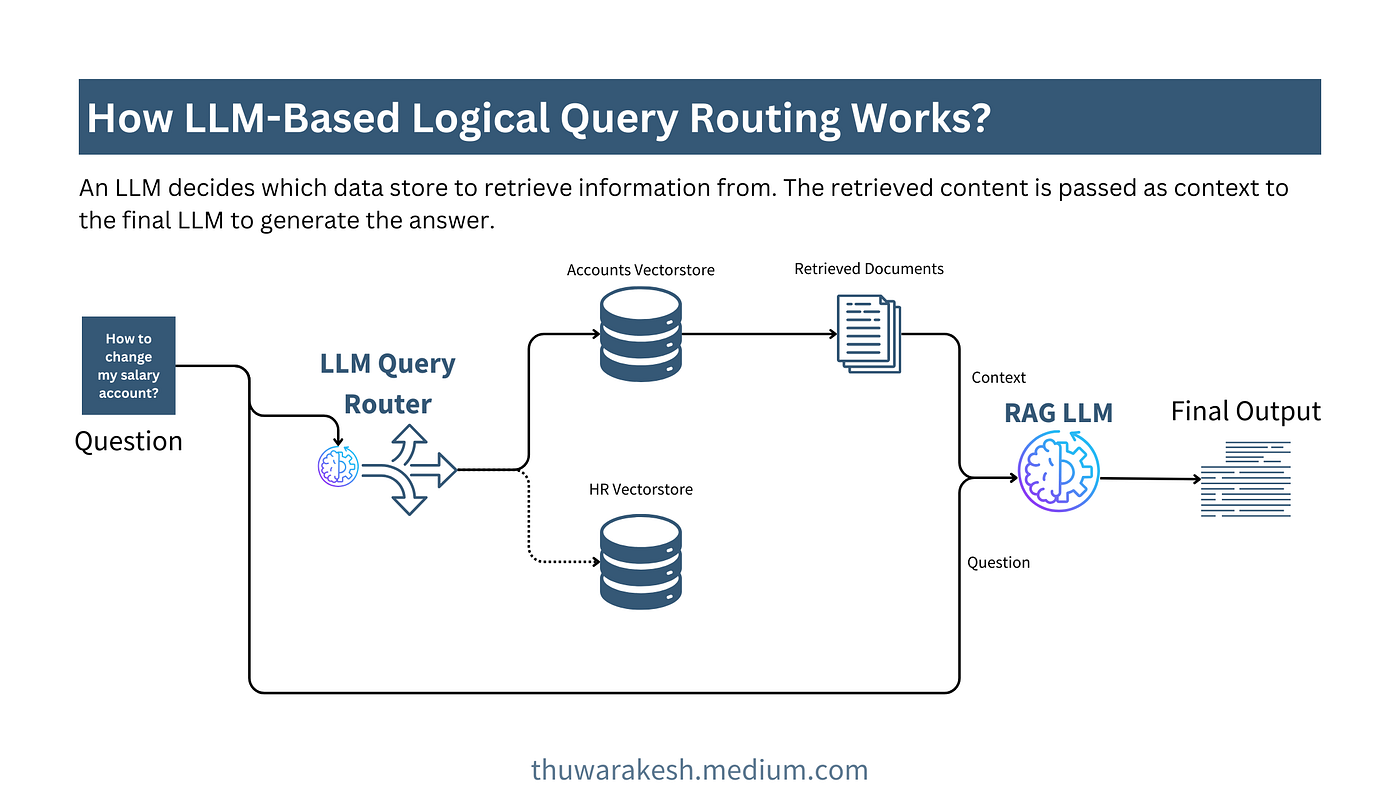

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'True'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = [Your LangChain API]
LANGCHAIN_PROJECT="RAG_basics"

os.environ['OPENAI_API_KEY'] = [Your OpenAi API]

In [3]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_openai import ChatOpenAI

# Define a data model for routing
class RouteQuery(BaseModel):
    """
    Data model to decide the most relevant data source for a programming question.
    Options are 'python_docs', 'js_docs', or 'golang_docs'.
    """
    datasource: Literal["python_docs", "js_docs", "golang_docs"]

# Configure the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Define the routing logic using a prompt
system_prompt = "You are an expert at deciding which programming language documentation is most relevant for a user question."
user_prompt = "{question}"

# Create the prompt template
prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt), ("human", user_prompt)]
)

# Combine the prompt with the structured LLM to create a router
router = prompt | structured_llm


/Users/mdwivedi/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Note: we used function calling to produce structured output.
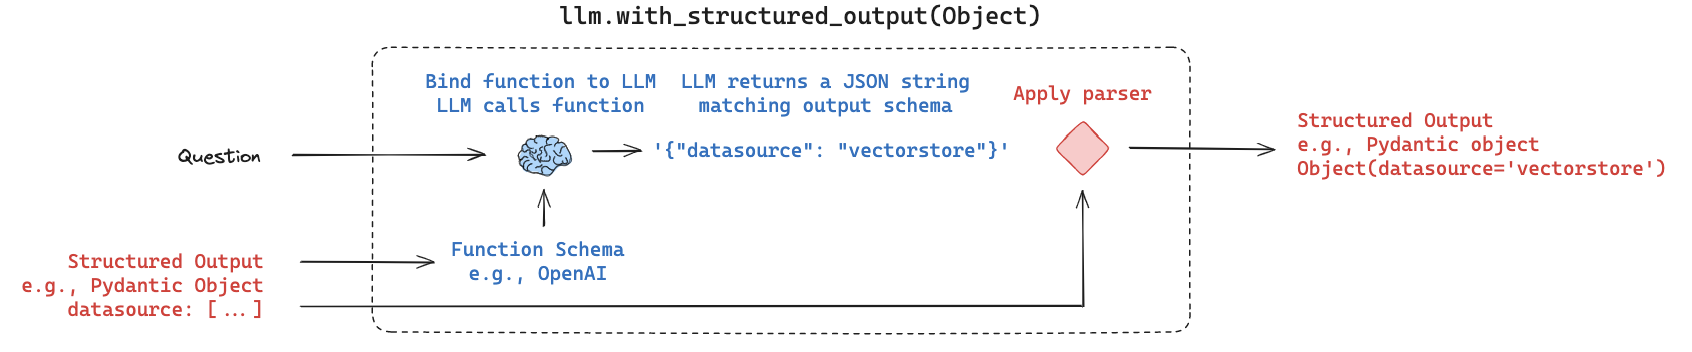

In [4]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""
print(question)
result = router.invoke({"question": question})

Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")



In [7]:
print(result)
result.datasource ## Refered to python database

datasource='python_docs'


'python_docs'

### We should define a logic which uses the output from the result.datasource

In [8]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [9]:
full_chain.invoke({"question": question})

'chain for python_docs'

## Semantic Routing
Semantic routing is a straightforward technique. Given two prompts and a query, the query is first embedded, and the cosine similarity between the query and each prompt is calculated. The prompt with the highest cosine similarity is selected as the most relevant and used to guide the LLM in generating a response.

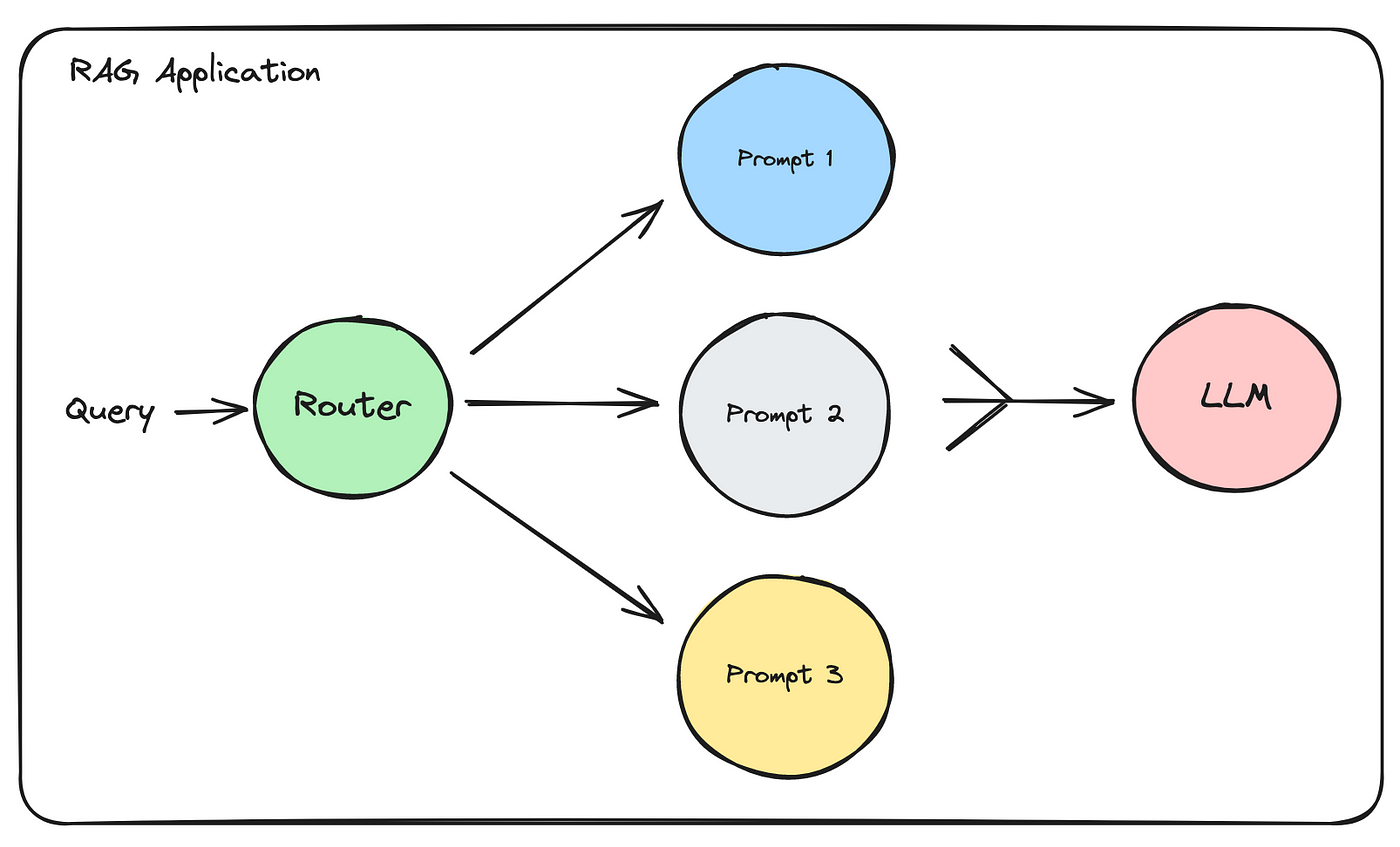

In [10]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

In [11]:
# Embed prompts
embeddings = OpenAIEmbeddings()
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt 
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)

In [12]:
chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole is a region in space where gravity is so strong that nothing, not even light, can escape from it. It is formed when a massive star collapses in on itself. The gravitational pull of a black hole is so intense that it distorts spacetime around it, creating a point of no return called the event horizon. Anything that crosses the event horizon is pulled into the black hole and can never escape.


# Query Construction

Query Construction is the process of formulating a query in a structured and optimized way to extract the most relevant information from a database, search engine, or other information retrieval systems. In the context of systems like RAG (Retrieval-Augmented Generation), this involves creating queries that align with the structure of the data source to ensure accurate and efficient retrieval.

Examples:
Natural Language Query: "What are the benefits of renewable energy?"
Constructed Query: "SELECT benefits FROM energy_sources WHERE type = 'renewable';"

Ref: https://blog.langchain.dev/query-construction/


## Query Structuring for Metadata Filters

Query Structuring for Metadata Filters involves organizing and refining queries using metadata tags or attributes to filter and retrieve specific subsets of data. Metadata filters are conditions or criteria based on attributes like date, category, author, or tags.

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.


In [7]:
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain_openai import ChatOpenAI

# dataset with metadata
data = [
    Document(
        page_content="Introduction to Python programming.",
        metadata={"title": "Introduction to Python", "author": "John Doe", "topic": "Programming", "date": "2023-05-01"}
    ),
    Document(
        page_content="Advanced concepts in Python functions.",
        metadata={"title": "Advanced Python Functions", "author": "Jane Smith", "topic": "Programming", "date": "2023-08-15"}
    ),
    Document(
        page_content="Basics of AI and Machine Learning.",
        metadata={"title": "AI and Machine Learning Basics", "author": "John Doe", "topic": "Artificial Intelligence", "date": "2022-12-10"}
    ),
    Document(
        page_content="Recent trends in Artificial Intelligence.",
        metadata={"title": "Recent Trends in AI", "author": "Emily White", "topic": "Artificial Intelligence", "date": "2023-09-05"}
    ),
    Document(
        page_content="Guide to web development using JavaScript.",
        metadata={"title": "Web Development with JavaScript", "author": "Michael Brown", "topic": "Web Development", "date": "2023-03-20"}
    ),
]

In [11]:
# Step 1: Embed the documents using OpenAI embeddings
embeddings = OpenAIEmbeddings()
vector_store = FAISS.from_documents(data, embeddings)

# Step 2: Define metadata filters
filters = {
    "topic": "Artificial Intelligence",
    "date": "2023-09-05",
}

# Step 3: Query with filters
retrieval_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    retriever=vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 3, "filters": filters})
)

# Step 4: Query the system
query = "Tell me about recent trends in AI"
response = retrieval_qa.run(query)

# Output response
print(response)

Recent trends in AI include the rise of explainable AI, which focuses on making AI systems more transparent and understandable to users. Another trend is the increased use of AI in natural language processing, enabling more advanced chatbots and language translation services. Additionally, AI ethics and bias mitigation have become important topics, as well as the integration of AI with other technologies like IoT and blockchain. Quantum computing is also being explored for its potential to revolutionize AI capabilities.
